In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
from collections import OrderedDict, Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, 
                              AdaBoostClassifier, BaggingRegressor, StackingClassifier)
from xgboost import XGBClassifier, plot_importance
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, f1_score 
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

In [6]:
df=pd.read_csv("updated_dataframe.csv")

In [7]:
df.columns

Index(['Unnamed: 0', 'Animal_ID', 'Name', 'DateTime', 'Outcome_Type',
       'Animal_Type', 'Sex', 'Age', 'Breed', 'Color', 'Found Location',
       'Intake Type', 'Intake Condition', 'Age_new', 'Neutered_Spayed',
       'Color_new', 'Mix', 'Breed_new', 'Outcome'],
      dtype='object')

# Dummies Variables & OHE

In [8]:
OHE_x=df.loc[:,['Animal_Type', 'Sex','Breed_new', 'Color_new', 
                'Intake Type','Intake Condition', 'Neutered_Spayed'#,'Mix'
               ]]

ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(OHE_x)
ohe_all = ohe.transform(OHE_x)
columns = ohe.get_feature_names(['Animal_Type', 'Sex','Breed', 'Color', 
                                 'Intake Type','Intake Condition', 'Neutered_Spayed'#,'Mix'
                                ])

ohe_all_df = pd.DataFrame(ohe_all, columns=columns, index=OHE_x.index)

In [9]:
ohe_all_df.shape

(75324, 310)

In [10]:
new_df_X= pd.concat([df.loc[:,['Age_new']],ohe_all_df], axis=1)
targe_y=df.loc[:,['Outcome']]

In [11]:
X_tr_v, X_test, y_tr_v, y_test=train_test_split(
    new_df_X, targe_y, test_size=0.2, random_state=41,stratify=targe_y)

X_tr, X_v, y_tr, y_v=train_test_split(
    X_tr_v, y_tr_v, test_size=0.2, random_state=41,stratify=y_tr_v)

In [12]:
def plot_roc(true, probas):
    auc = roc_auc_score(true, probas)
    plt.plot(fpr, tpr, marker='o')
    plt.plot([0,1],[0,1],c='violet',ls='--')
    plt.xlabel('1 - Specificity (FPR)')
    plt.ylabel('Sensitivity (TPR)');
    plt.title(f"Area Under the ROC Curve: {round(auc, 4)}");

# Handling Imbalanced

## 1. Oversampling

### Handling Imbalanced Classes-Oversampling

In [ ]:
#ros = RandomOverSampler(random_state=0)
#X_tr,y_tr = ros.fit_sample(X_tr,y_tr)

### SMOTE- Synthetic Minority Oversampling Technique

In [ ]:
#from imblearn.over_sampling import SMOTE
#X_tr,y_tr = SMOTE(random_state=42).fit_sample(X_tr,y_tr)

### ADASYN (ADAptive SYNthetic oversampling)

In [ ]:
#from imblearn.over_sampling import ADASYN
#X_tr,y_tr = ADASYN(random_state=42).fit_sample(X_tr,y_tr)

## 2. Undersampling

In [13]:
X_tr,y_tr = RandomUnderSampler(random_state=42).fit_sample(X_tr,y_tr)

In [14]:
y_tr.Outcome.value_counts()

0    2367
1    2367
Name: Outcome, dtype: int64

# Classification Model- XGBoost

### train and validation

In [24]:
XGB_model= XGBClassifier()
XGB_model.fit(X_tr, y_tr)
print("training score: {}".format(XGB_model.score(X_tr, y_tr)))
print("testing score: {}".format(XGB_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, XGB_model.predict(X_v)))

[15:44:42] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training score: 0.9127587663709337
testing score: 0.8813474941918353
confusion_matrix: 
 [[10119  1341]
 [   89   503]]


              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11460
           1       0.27      0.85      0.41       592

    accuracy                           0.88     12052
   macro avg       0.63      0.87      0.67     12052
weighted avg       0.96      0.88      0.91     12052



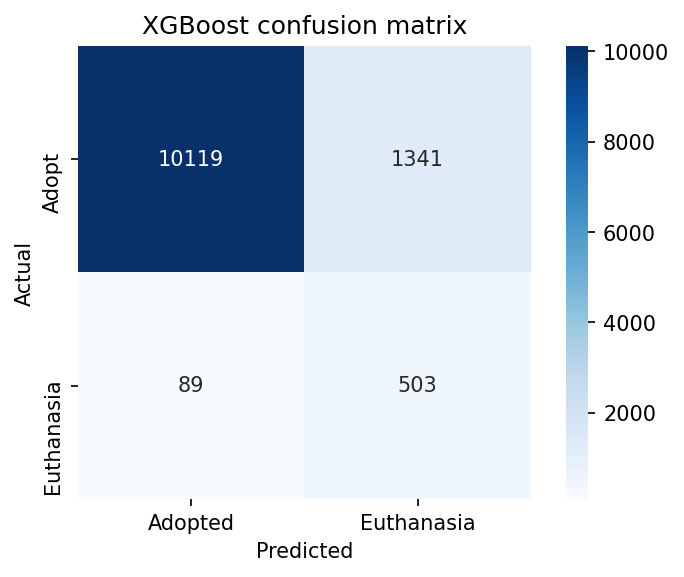

In [25]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_v, XGB_model.predict(X_v)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');
print(classification_report(y_v, XGB_model.predict(X_v)))

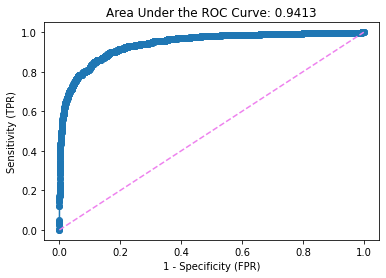

In [20]:
proba=XGB_model.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

### test

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14325
           1       0.27      0.83      0.40       740

    accuracy                           0.88     15065
   macro avg       0.63      0.86      0.67     15065
weighted avg       0.95      0.88      0.91     15065



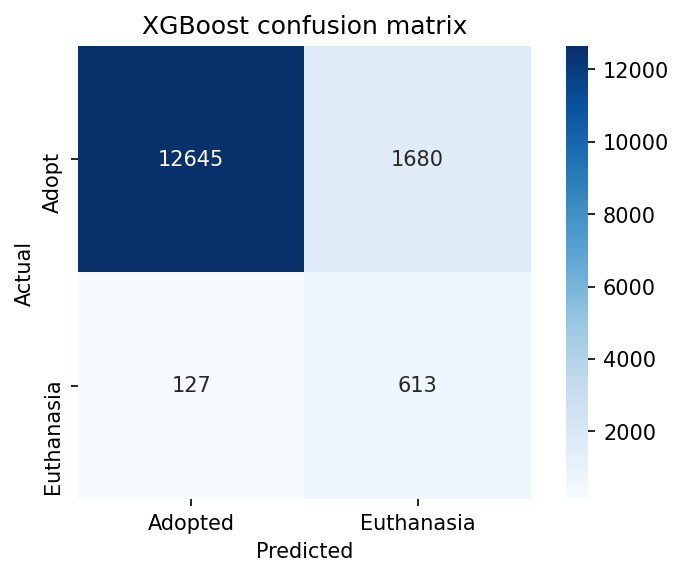

In [26]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, XGB_model.predict(X_test)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');
print(classification_report(y_test, XGB_model.predict(X_test)))

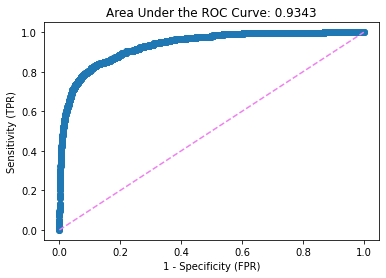

In [27]:
proba=XGB_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
plot_roc(y_test, proba)

### Visualize XGBoost

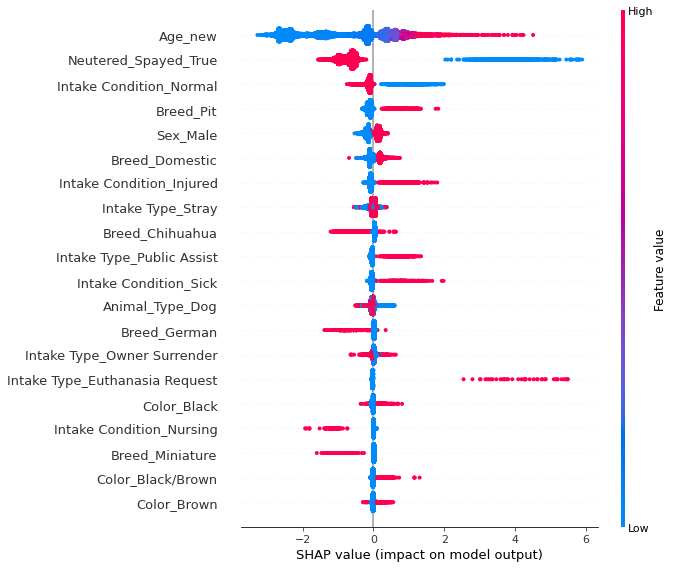

In [59]:
import shap
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

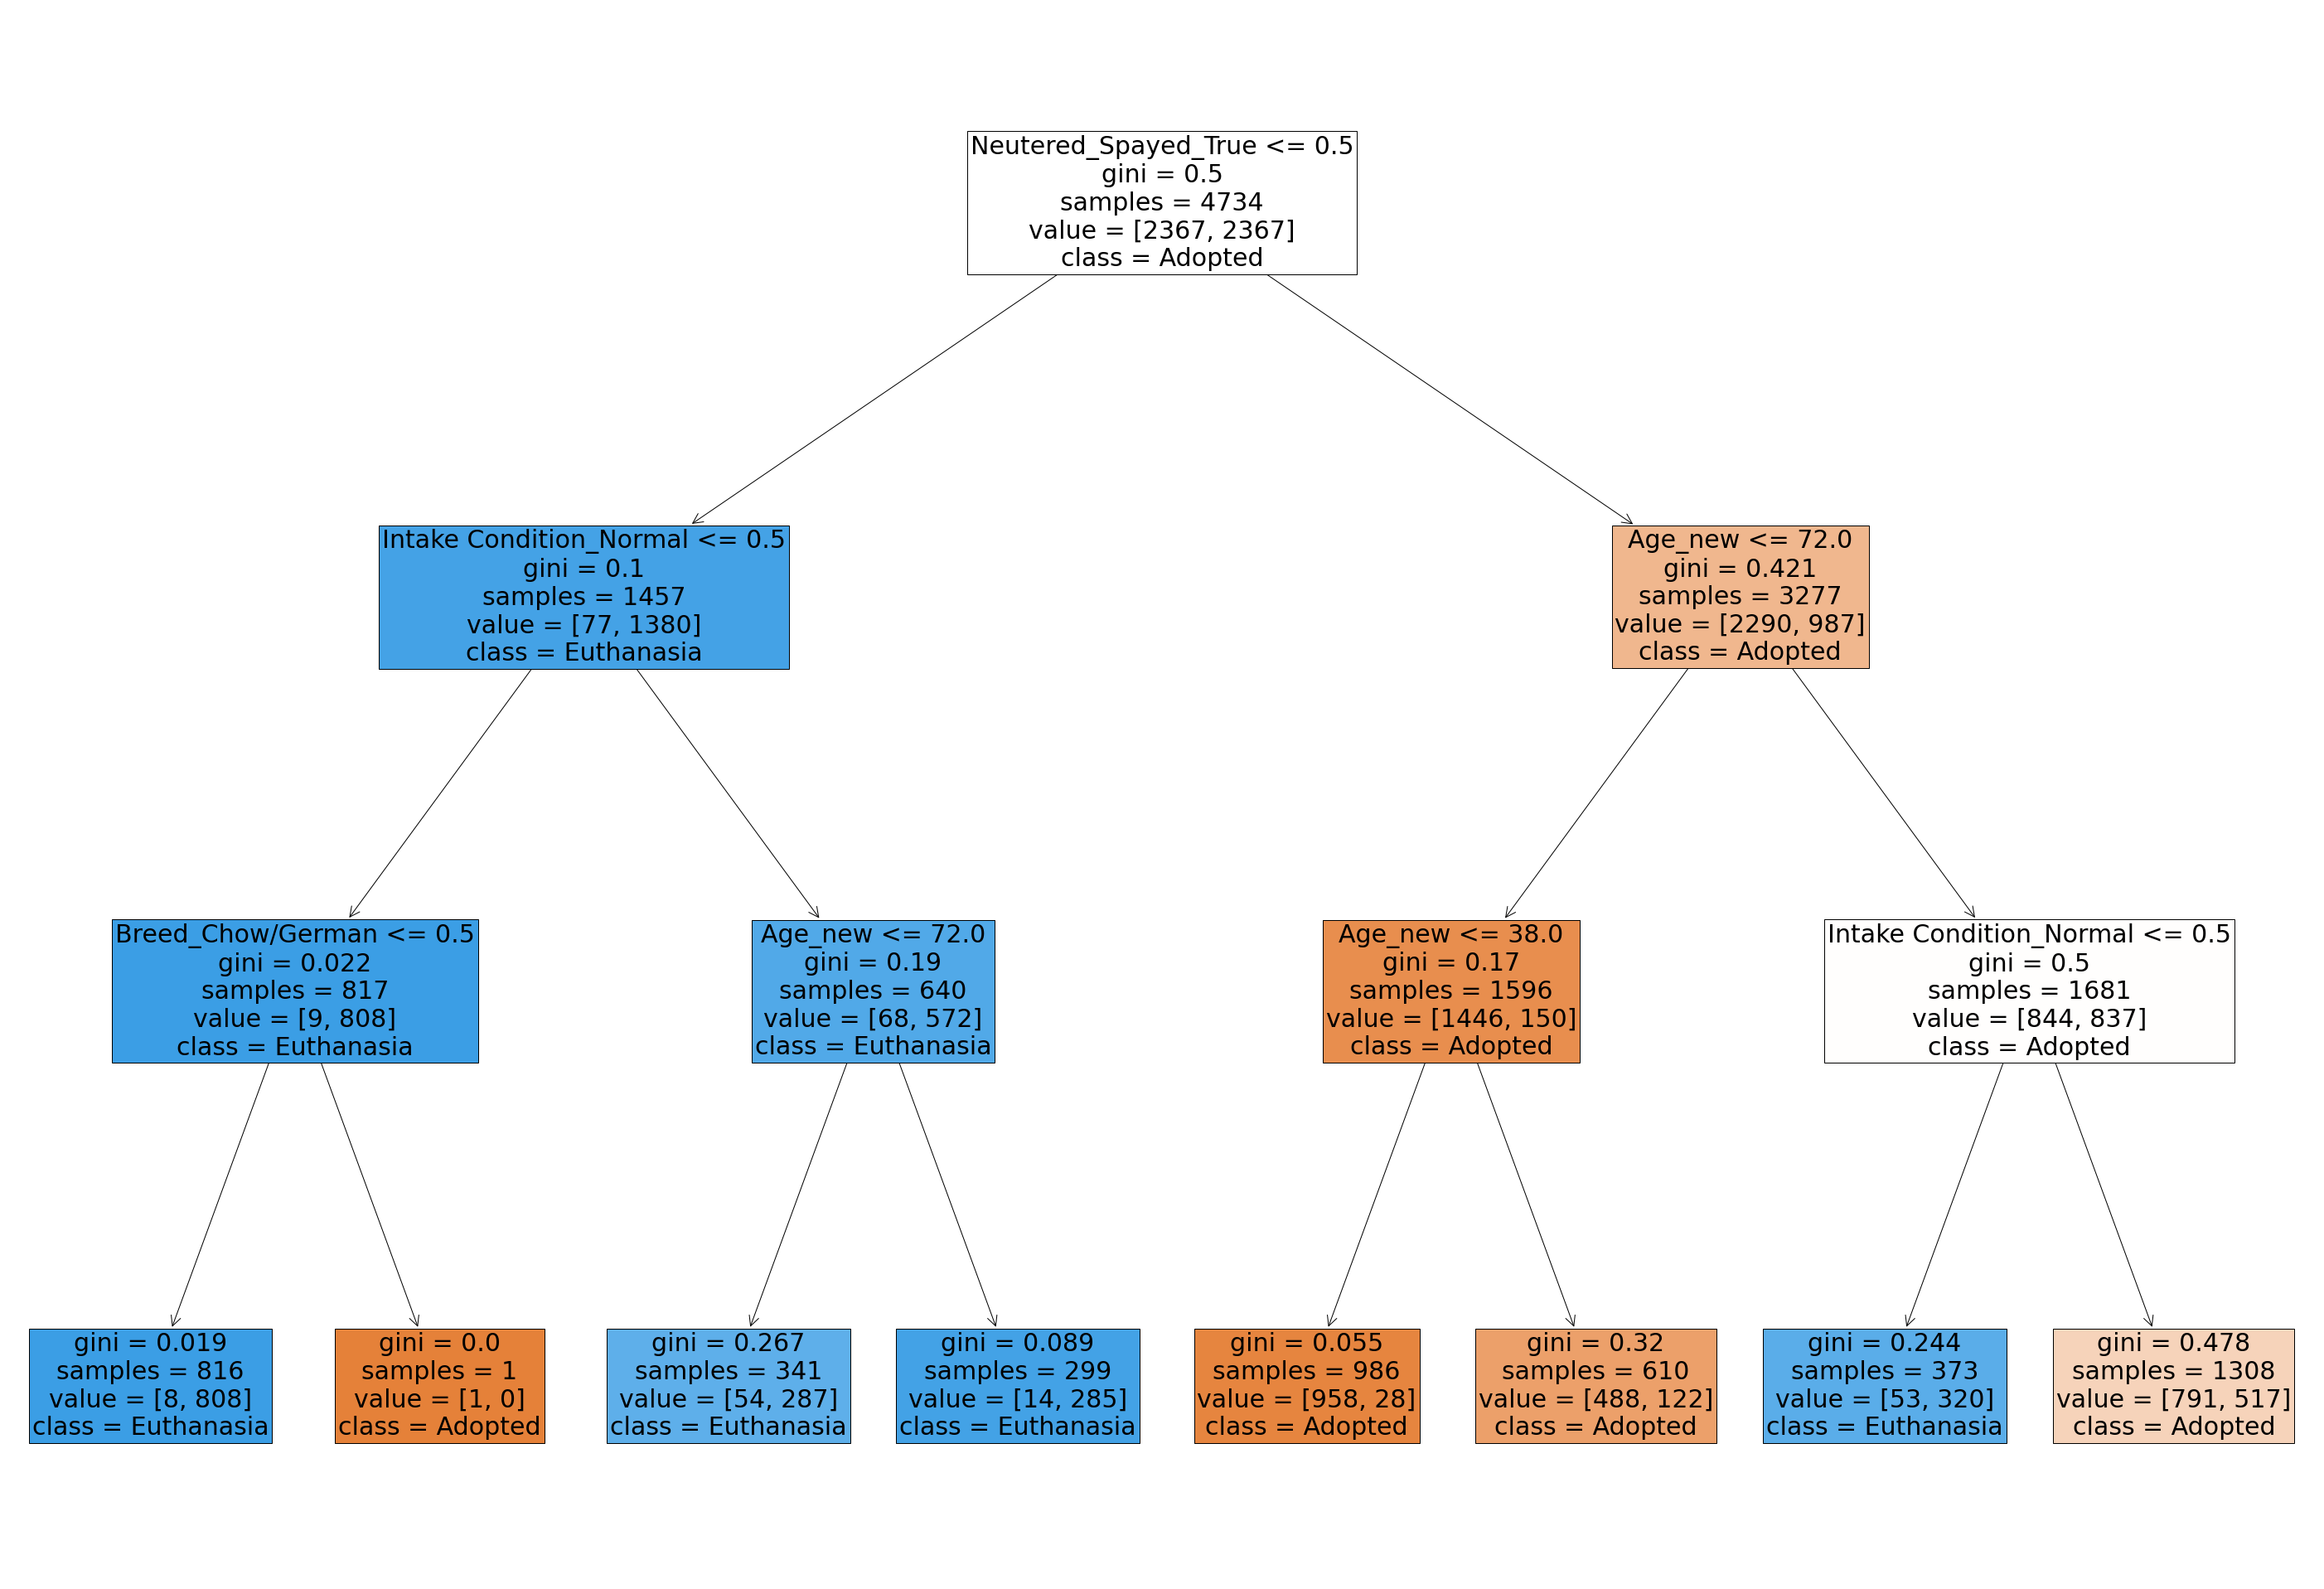

In [60]:
from sklearn import tree
# create and train model
clf = tree.DecisionTreeClassifier(max_depth=3)

clf.fit(X_tr, y_tr)

# plot tree
plt.figure(figsize=(50,35))  # set plot size (denoted in inches)
tree.plot_tree(clf, fontsize=30,feature_names=X_tr.columns,  
                   class_names=['Adopted','Euthanasia'],
                   filled=True)
plt.show()

# Classification Model- Logistic Regression

### train and validation

In [28]:
lm = LogisticRegression()
lm.fit(X_tr, y_tr)
print("training score: {}".format(lm.score(X_tr, y_tr)))
print("testing score: {}".format(lm.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, lm.predict(X_v)))

training score: 0.857625686523025
testing score: 0.8739628277464321
confusion_matrix: 
 [[10047  1413]
 [  106   486]]


              precision    recall  f1-score   support

           0       0.99      0.88      0.93     11460
           1       0.26      0.82      0.39       592

    accuracy                           0.87     12052
   macro avg       0.62      0.85      0.66     12052
weighted avg       0.95      0.87      0.90     12052



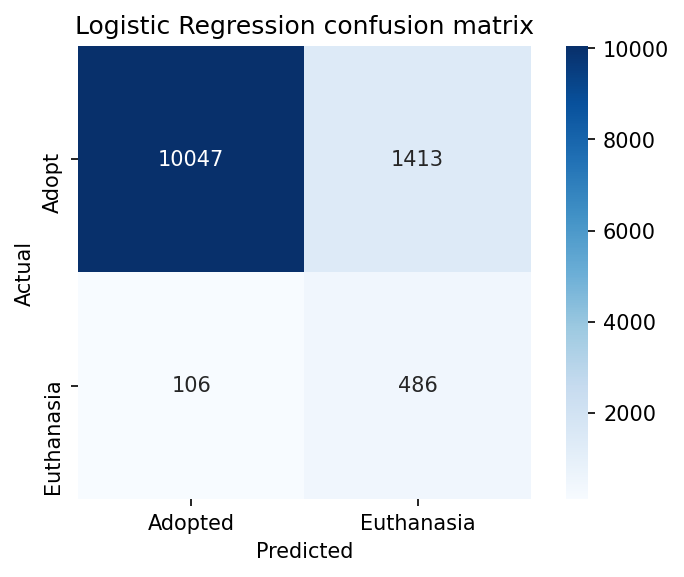

In [29]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_v, lm.predict(X_v)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');
print(classification_report(y_v, lm.predict(X_v)))

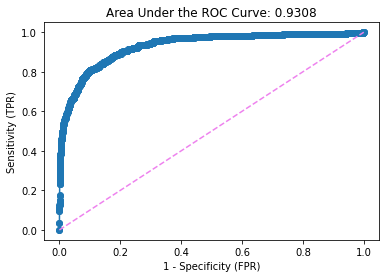

In [30]:
proba=lm.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

### test

              precision    recall  f1-score   support

           0       0.99      0.88      0.93     14325
           1       0.25      0.81      0.38       740

    accuracy                           0.87     15065
   macro avg       0.62      0.84      0.66     15065
weighted avg       0.95      0.87      0.90     15065



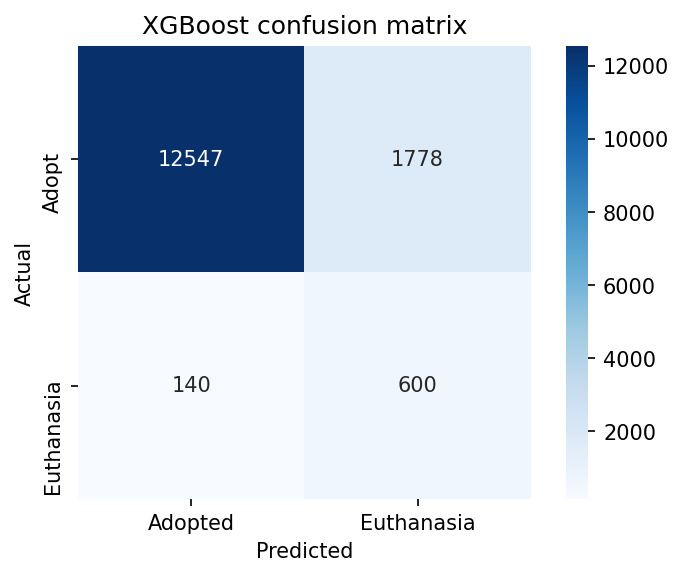

In [31]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, lm.predict(X_test)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');
print(classification_report(y_test, lm.predict(X_test)))

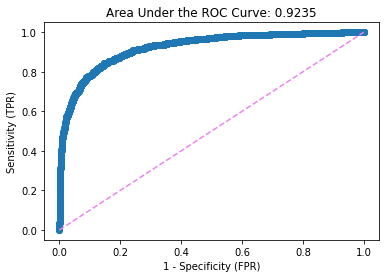

In [32]:
proba=lm.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
plot_roc(y_test, proba)

# Classification Model- K Neighbors Classifier

### train and validation

In [38]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr, y_tr)
print("training score: {}".format(lm.score(X_tr, y_tr)))
print("testing score: {}".format(lm.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, lm.predict(X_v)))

training score: 0.857625686523025
testing score: 0.8739628277464321
confusion_matrix: 
 [[10047  1413]
 [  106   486]]


              precision    recall  f1-score   support

           0       0.99      0.84      0.91     11460
           1       0.20      0.80      0.33       592

    accuracy                           0.84     12052
   macro avg       0.60      0.82      0.62     12052
weighted avg       0.95      0.84      0.88     12052



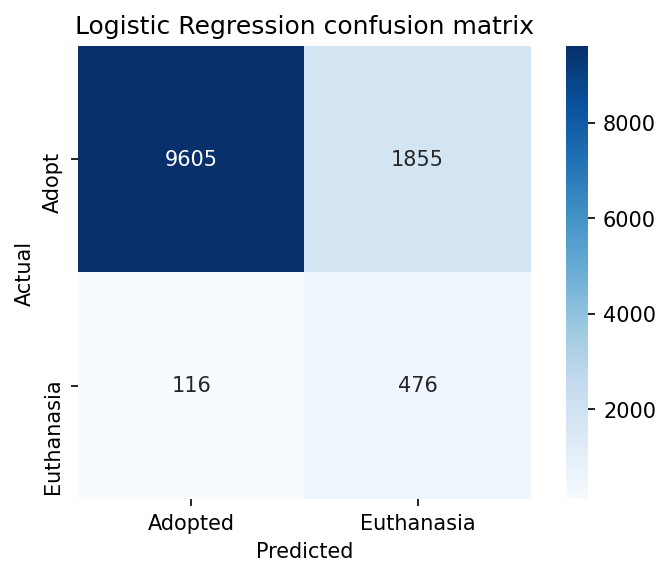

In [39]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_v, knn.predict(X_v)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Logistic Regression confusion matrix');
print(classification_report(y_v, knn.predict(X_v)))

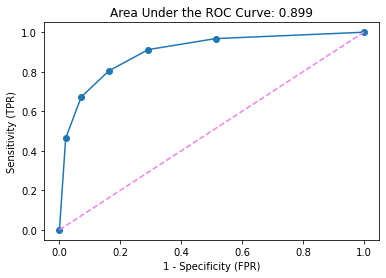

In [40]:
proba=knn.predict_proba(X_v)[:,1]
fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

### test

              precision    recall  f1-score   support

           0       0.99      0.84      0.91     14325
           1       0.20      0.78      0.32       740

    accuracy                           0.84     15065
   macro avg       0.59      0.81      0.61     15065
weighted avg       0.95      0.84      0.88     15065



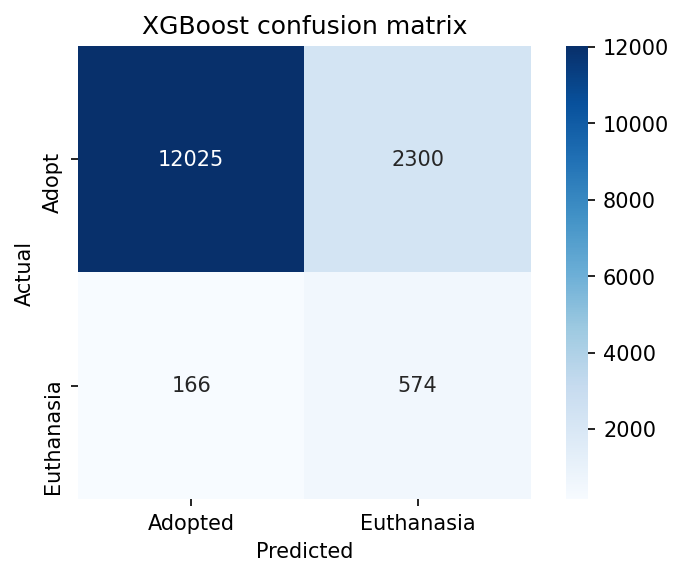

In [41]:
plt.figure(dpi=150)
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test)), cmap=plt.cm.Blues,
            annot=True, square=True, xticklabels=['Adopted','Euthanasia'], yticklabels=['Adopt','Euthanasia'],fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost confusion matrix');
print(classification_report(y_test, knn.predict(X_test)))

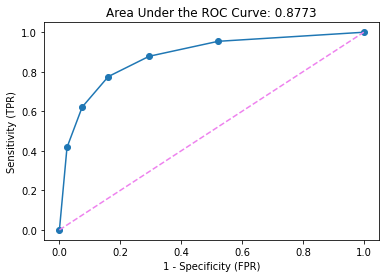

In [42]:
proba=knn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, proba)
plot_roc(y_test, proba)

# Classification Model- Naive Bayes - Multinomial

In [43]:
nb1 = MultinomialNB()
nb1.fit(X_tr, y_tr)
print("training score: {}".format(nb1.score(X_tr, y_tr)))
print("testing score: {}".format(nb1.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, nb1.predict(X_v)))
print(classification_report(y_v, nb1.predict(X_v)))

training score: 0.7207435572454584
testing score: 0.8139727846000664
confusion_matrix: 
 [[9442 2018]
 [ 224  368]]
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     11460
           1       0.15      0.62      0.25       592

    accuracy                           0.81     12052
   macro avg       0.57      0.72      0.57     12052
weighted avg       0.94      0.81      0.86     12052



# Classification Model- Decision Tree

In [44]:
dt_model = DecisionTreeClassifier(max_depth=7)
dt_model.fit(X_tr, y_tr)
print("training score: {}".format(dt_model.score(X_tr, y_tr)))
print("testing score: {}".format(dt_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, dt_model.predict(X_v)))
print(classification_report(y_v, dt_model.predict(X_v)))

training score: 0.8690325306294888
testing score: 0.9120477928974444
confusion_matrix: 
 [[10529   931]
 [  129   463]]
              precision    recall  f1-score   support

           0       0.99      0.92      0.95     11460
           1       0.33      0.78      0.47       592

    accuracy                           0.91     12052
   macro avg       0.66      0.85      0.71     12052
weighted avg       0.96      0.91      0.93     12052



# Classification Model- Random Forest

In [45]:
rf_model = RandomForestClassifier(n_estimators=500)
rf_model.fit(X_tr, y_tr)
print("training score: {}".format(rf_model.score(X_tr, y_tr)))
print("testing score: {}".format(rf_model.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, rf_model.predict(X_v)))
print(classification_report(y_v, rf_model.predict(X_v)))

training score: 0.9729615547106042
testing score: 0.8628443411881845
confusion_matrix: 
 [[9892 1568]
 [  85  507]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     11460
           1       0.24      0.86      0.38       592

    accuracy                           0.86     12052
   macro avg       0.62      0.86      0.65     12052
weighted avg       0.95      0.86      0.90     12052



# Quick test for few models 

In [46]:
def quick_test(model, X, y):
    xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
    model.fit(xtrain, ytrain)
    return model.score(xtest, ytest)

def quick_test_afew_times(model, X, y, n=5):
    return np.mean([quick_test(model, X, y) for j in range(n)])

In [47]:
knn_model= KNeighborsClassifier(n_neighbors=5)
lr_model = LogisticRegression(C=0.95)
nb_model = MultinomialNB()
XGB_model= XGBClassifier()
dt_model = DecisionTreeClassifier(max_depth=3)
rf_model = RandomForestClassifier(n_estimators=100)
et_model = ExtraTreesClassifier()
ada_model = AdaBoostClassifier()

In [48]:
print('knn_model:',quick_test_afew_times(knn_model, X_tr_v, y_tr_v))
print('LogisticRegression:',quick_test_afew_times(lr_model, X_tr_v, y_tr_v))
print('GaussianNB:',quick_test_afew_times(nb_model, X_tr_v, y_tr_v))
print('XGB:',quick_test_afew_times(XGB_model, X_tr_v, y_tr_v))
print('DecisionTree:',quick_test_afew_times(dt_model, X_tr_v, y_tr_v))
print('RandomForest:',quick_test_afew_times(rf_model, X_tr_v, y_tr_v))
print('ExtraTrees:',quick_test_afew_times(et_model, X_tr_v, y_tr_v))
print('AdaBoost:',quick_test_afew_times(ada_model, X_tr_v, y_tr_v))

knn_model: 0.9612789025334662
LogisticRegression: 0.9672640778847217
GaussianNB: 0.8706494081203674
[15:58:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:43] WARNING: /Users/travis/build/dmlc/xgboost/s

# Emsembling Model

In [49]:
model_names = ["knn_model","lr_model", "nb_model",
               "XGB_model","dt_model","rf_model","et_model","ada_model"]

In [50]:
model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

### Max Voting

In [51]:
# create voting classifier
voting_classifer = VotingClassifier(estimators=model_list,
                                    voting='hard', 
                                    # <-- sklearn calls this hard voting
                                    n_jobs=-1)
voting_classifer.fit(X_tr, y_tr)

VotingClassifier(estimators=[('knn_model', KNeighborsClassifier()),
                             ('lr_model', LogisticRegression(C=0.95)),
                             ('nb_model', MultinomialNB()),
                             ('XGB_model',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_...
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=8,
                                            num_parallel_tree

In [52]:
y_pred = voting_classifer.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(voting_classifer.score(X_tr, y_tr)))
print("testing score: {}".format(voting_classifer.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, voting_classifer.predict(X_v)))
print(classification_report(y_v, y_pred))

accuracy score:  0.9071523398606041
training score: 0.9138149556400507
testing score: 0.9071523398606041
confusion_matrix: 
 [[10445  1015]
 [  104   488]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     11460
           1       0.32      0.82      0.47       592

    accuracy                           0.91     12052
   macro avg       0.66      0.87      0.71     12052
weighted avg       0.96      0.91      0.93     12052



### Weight Voting

In [53]:
weights = [1,1,1,1.5,1,1.5,1,1]
voting_weight= VotingClassifier(estimators=model_list,
                                    voting='soft',
                                    weights=weights,
                                    n_jobs=-1)
voting_weight.fit(X_tr, y_tr)



VotingClassifier(estimators=[('knn_model', KNeighborsClassifier()),
                             ('lr_model', LogisticRegression(C=0.95)),
                             ('nb_model', MultinomialNB()),
                             ('XGB_model',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1, gamma=0,
                                            gpu_id=-1, importance_type='gain',
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_...
                                            num_parallel_tree=1, random_state=0,
                                            reg_alpha=0, reg_lambda=1,
                                            scale_po

In [54]:
y_pred = voting_weight.predict(X_v)
print("accuracy score: ",accuracy_score(y_v, y_pred))
print("training score: {}".format(voting_weight.score(X_tr, y_tr)))
print("testing score: {}".format(voting_weight.score(X_v, y_v)))
print("confusion_matrix: \n", confusion_matrix(y_v, voting_weight.predict(X_v)))
print(classification_report(y_v, y_pred))

accuracy score:  0.8860769996681048
training score: 0.9387410223912125
testing score: 0.8860769996681048
confusion_matrix: 
 [[10175  1285]
 [   88   504]]
              precision    recall  f1-score   support

           0       0.99      0.89      0.94     11460
           1       0.28      0.85      0.42       592

    accuracy                           0.89     12052
   macro avg       0.64      0.87      0.68     12052
weighted avg       0.96      0.89      0.91     12052



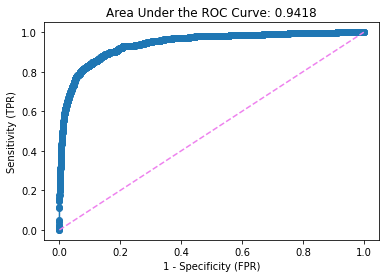

In [55]:
proba=voting_weight.predict_proba(X_v)[:,1]

fpr, tpr, thresholds = roc_curve(y_v, proba)
plot_roc(y_v, proba)

### Visualizing the weighted Voting System

In [57]:
probas = [c.predict_proba(X_tr) for n,c in model_list]
probas += [voting_weight.predict_proba(X_tr)]
# get class probabilities for the first sample in the dataset
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]

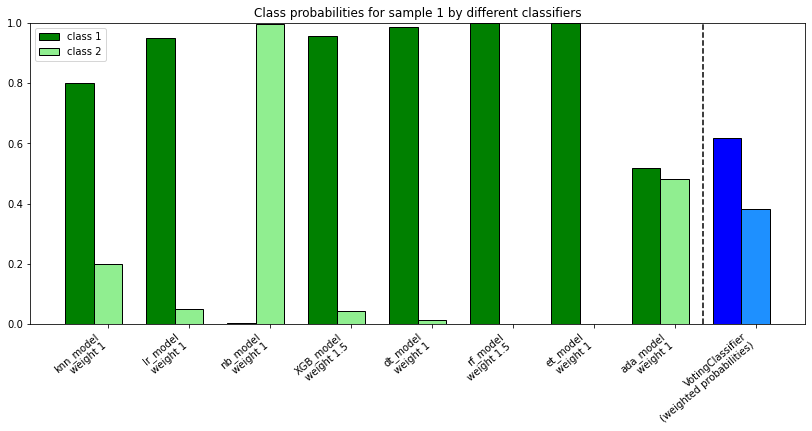

In [58]:
# plotting
N = 9  # number of groups
ind = np.arange(N)  # group positions
width = 0.35  # bar width

fig, ax = plt.subplots()

# bars for classifier 1-7
p1 = ax.bar(ind, np.hstack(([class1_1[:-1], [0]])), 
            width,
            color='green', 
            edgecolor='k')
p2 = ax.bar(ind + width, np.hstack(([class2_1[:-1], [0]])), 
            width,
            color='lightgreen', 
            edgecolor='k')

# bars for VotingClassifier
p3 = ax.bar(ind, [0,0,0,0,0,0,0,0, class1_1[-1]], 
            width,
            color='blue', 
            edgecolor='k')
p4 = ax.bar(ind + width, [0,0,0,0,0,0,0,0, class2_1[-1]], 
            width,
            color='dodgerblue', 
            edgecolor='k')

# plot annotations
plt.axvline(N - 1.3, color='k', linestyle='dashed')
ax.set_xticks(ind + width)
x_labels = [f"{n}\nweight {weights[i]}" for i, n in enumerate(model_names)]
ax.set_xticklabels(
    x_labels + ['VotingClassifier\n(weighted probabilities)'],
    rotation=40,
    ha='right')

plt.ylim([0, 1])
plt.title('Class probabilities for sample 1 by different classifiers')
plt.legend([p1[0], p2[0]], ['class 1', 'class 2'], loc='upper left')
plt.tight_layout()
plt.gcf().set_size_inches(12, 8)
plt.show()

